**BetaCoronavirus Genotyping for Armenian WGS isolates: since Dec2019 Wuhan Outbreak, and Mapping them to HGVS-Protein Level Mutations with CDS Modulo3**

__________________________________________________________________________________________________________________

### Packages Installation:

**Entre EDirect:** Search Engine for NCBI Database
**Command$:** sudo apt-get install -y ncbi-entrez-direct

**Emboss:**  European molecular biology open software suite
**Command$:** sudo apt install -y emboss 

**Blast:** Basic Local Alignment Search tools
1. Installers and source code are available from [Download and install BLAST+](#https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=Download)

2. Or you can run the direct command for installation: **sudo apt install ncbi-blast+**

**DWGSIM:** a whole Genome Simulator for Next-Generation Sequencing
**Command$:** sudo apt install -y dwgsim

**V-pipe:** V-pipe is a pipeline designed for analysing NGS data of short viral genomes, Installers and source code are available from the following link: [Download the installer](https://github.com/cbg-ethz/V-pipe/tree/sars-cov2)

**CD-HIT:** is a very widely used program for clustering and comparing protein or nucleotide sequences.
**Command$:** sudo apt install cd-hit

**minimap2:** Please follow the link for the installation: [Download the installer](#https://github.com/lh3/minimap2#install)

**bcftools:** **Command$:** sudo apt install -y bcftools | Link for: [Download the installer](#https://samtools.github.io/bcftools/)

**samtools:** 
**Command$:** sudo apt-get install -y samtools | Link for: [Download the installer](#https://samtools.github.io/bcftools/)

____________________________________________________________

**Flow Chart for the Analysis**



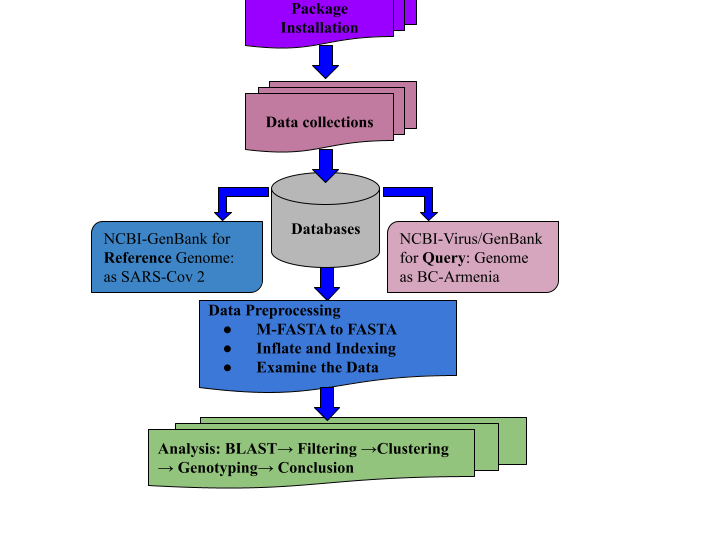

________________________

### Fetching the GenBank format of the files:

In [ ]:
$ efetch -db nuccore -id NC_045512 -format gb > refs/NC_045512.gb

### Formating the GenBank dataset in FASTA:

In [ ]:
$ cat refs/NC_045512.gb | seqret -filter -osformat fasta > refs/
NC_045512.fa

### Retrieving the SARS nCoV-2 Annotation GFF: Gene Feature Format file:

In [ ]:
$ wget -c https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2
    _ASM985889v3_genomic.gff.gz

### Downloading the BC BLAST databases [00 to 07]

In [ ]:
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.00.tar.gz
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.01.tar.gz
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.02.tar.gz
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.03.tar.gz
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.04.tar.gz
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.05.tar.gz
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.06.tar.gz
$ wget -c https://ftp.ncbi.nlm.nih.gov/blast/db/Betacoronavirus.07.tar.gz

### Indexing the BLAST Databses Files [00 to 07]

In [ ]:
$ gunzip -c human_genomic.00.tar.gz | tar -xvf -
$ gunzip -c human_genomic.01.tar.gz | tar -xvf -
$ gunzip -c human_genomic.02.tar.gz | tar -xvf -
$ gunzip -c human_genomic.03.tar.gz | tar -xvf -
$ gunzip -c human_genomic.04.tar.gz | tar -xvf -
$ gunzip -c human_genomic.05.tar.gz | tar -xvf -
$ gunzip -c human_genomic.06.tar.gz | tar -xvf -
$ gunzip -c human_genomic.07.tar.gz | tar -xvf -

### Runnig the BLAST

In [ ]:
$ blastn -db Betacoronavirus -query ./refs/NC_045512.fa -outfmt 7

### BatchEntrez D/load of 0-eValue only for 500 Hits:

In [ ]:
$ blastn -db Betacoronavirus -query ./refs/NC_045512.fa -outfmt 7 | grep -v "^#" | tee inithits.txt
$ cat inithits.txt | wc -l
$ cat inithits.txt | awk '{print NF}' | datamash mean 1
$ awk '$11 ~ /0.0/ {print $0}' inithits.txt | wc -l

### Extracting the duplicates amongst 0-eV Accns:

In [ ]:
$ awk '$11 ~ /0.0/ {print $0}' inithits.txt | tee bc500.txt
$ cat bc500.txt | awk '{print $2}' | head -n5

In [ ]:
$ cat bc500.txt | awk '{print $2}' | awk '!visited[$0]++' | wc -l
$ cat bc500.txt | awk '{print $2}' | awk '!visited[$0]++' | tee accn500.tx

### Creating the BetaCoronavirus Multi-FastA file:

In [ ]:
$ cat accn500.txt | parallel -j 1 blastdbcmd -db Betacoronavirus -entry {} > betacorona.fa

In [ ]:
$ seqkit stats ./refs/NC_045512.fa
$ seqkit stats betacorona.fa

### Clustering

In [ ]:
$ cd-hit -i betacorona.fa -o out

In [ ]:
$ head out.clstr

### Median Similarity across Betacoronavirus

In [ ]:
$ cat out.clstr | grep at | awk ' { print $5 } '| tr -d '%' | datamash min 1 max 1 median 1

### Align the 500 BetaCoronavirus Whole Genomes to RefSeq (Wuhan)

In [ ]:
$ minimap2 -a ./refs/NC_045512.fa betacorona.fa | samtools sort > align.bam

### Indexing the Alignments & Calling Variants (not-filter) from the BetaCoronavirus BAM file

In [ ]:
$ samtools index align.bam

### Computing the genotypes from the alignment file with pileup

In [ ]:
$ bcftools mpileup -B -Ovu -f./refs/NC_045512.fa align.bam > genotypes.vcf

### Variants calling from BC genotypes.

In [ ]:
$ bcftools call -vc -Ov genotypes.vcf > variants.vcf
$ cat variants.vcf | grep -v "^#" | awk '{print $1"\t"$2"\t"$4"\t"$5"\t"$9"\t"$10}'

### Performing the genoytpe for the Betacoronavirus samples:

Genotyping is a frequently used term that may cover a wide variety of tasks. In our case we wish to **identify the patterns** in the genome and connect these patterns to other known information. For example we would like to know if a certainvariation occurs on a continent or in a city, or that certain mutations appeared later in time.
IIT is a tool that, when given a chromosomal position groups the genomes by the alleles (the variants at that posion), then shows how many genomes have a particular allelle
combination.

**Sample Genotyping OUTPUT:** 

To perform a genotyping we need to specify an alignment file in sorted and indexed BAM format (that contains each aligned genome), a reference genome (that tells us what the reference allele is), a chromosomal name and a genomic position.In nutshell, the genotype command will group and print genomes that have the identical alleles at a chromosomal position. **For example:**, let’s take position 1000, the nucleotide in the reference at that position is a T. We also know that there are no variations in our alignment file at that position thus all genotypes will be T/T.

### Downloading the Python- Script for GenoType

In [ ]:
$ wget -c http://data.biostarhandbook.com/books/corona/code/genotype.py

### Geno-Typing: Output

In [ ]:
$ python3 genotype.py align.bam NC_045512 241 | head -n3
$ python3 genotype.py align.bam NC_045512 241 | tail -n3

In [2]:
# access to read
from IPython.display import HTML
HTML("""
<style>
h1,h2,h3 {
	margin: 1em 0 0.5em 0;
	font-weight: 600;
	font-family: 'Titillium Web', sans-serif;
	position: relative;  
	font-size: 36px;
	line-height: 40px;
	padding: 15px 15px 15px 2.5%;
	color: #13003A;
	box-shadow: 
		inset 0 0 0 1px rgba(53,86,129, 1), 
		inset 0 0 5px rgba(53,86,129, 1),
		inset -285px 0 35px white;
	border-radius: 0 10px 0 15px;
	background: #fff
    
}
</style>
""")


## ================================ ##

**Note:** above code is markdown code which is not the part of analysis 